# Capstone Project: Detecting Atelectasis in lung X-Rays

## Problem statement
Lung X-ray interpretation is not simple, and requires specialists with many years of experience. In spite of heavy trainings the specialists go thru, they could make mistakes as they are humans and could be easily affected by factors such as fatigue which could impact their decision making proces. This is dangerous because they are dealing with patients lifes and sending a positive patient home could kill them.

## The goal

The goal is to implement a model with a deployable accuracy which aid experts in their decision making process in order to reduce mistakes

## Methodology

* Data is obtained from [Stanford ML Group](https://stanfordmlgroup.github.io/competitions/chexpert/) which consists of two types of xray images (Frontal and lateral) along with 14 pathologies 

* Data is cleaned and the Atelectasis feature is extracted 

* Experimentation with modeling is performed on the data to determine which works the best

**Note:** This notebook is a final compilations of multiple notebook which were used to run tests during the project. Therefore, **some blocks are not ment to be executed sequentially** but to select one of them. They were placed together here to facelitate the storyline only.

In [2]:

# This was needed for Tensorflow1 but please update to Tensorflow2
'''import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)'''


import tensorflow as tf
import seaborn as sns

import pandas as pd
import numpy as np
from numpy import expand_dims
import os
import math
from time import time
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from PIL import Image
import pickle
import tensorboard
from keras.callbacks import TensorBoard
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import random_brightness, random_rotation, random_shift


Using TensorFlow backend.


In [3]:
# Please make sure that your version is '2.2.0'
tf.__version__

'2.2.0'

### Functions
Below is a block full of methods which are used during the notebook. They were all grouped here to streamline the storyline and enhance the flow of the code.

In [4]:
def viz_progress(history,title):
    '''
    A simple function to plot 2 graphs, one for AUC and the other for loss
    '''
    f,ax = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
    f.suptitle(title)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train loss', 'val loss'])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('binary_crossentropy')
    ax[1].plot(history.history['auc'])
    ax[1].plot(history.history['val_auc'])
    ax[1].legend(['train AUC', 'val AUC'])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('Area Under Curve')
    ax[1].set_ylim(0,1)
    plt.show()

def viz_progress1(history,title):
        '''
    A simple function to plot 3 graphs, one for AUC and the other for loss
    and the third is for accuracy
    '''
    f,ax = plt.subplots(nrows=1, ncols=3, figsize = (20,5))
    f.suptitle(title)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train loss', 'val loss'])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('binary_crossentropy')
    ax[1].plot(history.history['auc'])
    ax[1].plot(history.history['val_auc'])
    ax[1].legend(['train AUC', 'val AUC'])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('Area Under Curve')
    ax[1].set_ylim(0,1)
    ax[2].plot(history.history['binary_accuracy'])
    ax[2].plot(history.history['val_binary_accuracy'])
    ax[2].legend(['train Accuracy', 'val Accuracy'])
    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('Binary Accuracy')
    ax[2].set_ylim(0,1)
    plt.show()
    
    
def plot_roc_curve(true_y, pred_y):
    '''
    A function to plot the roc graph given the label and predicted labels'''
    lr_fpr, lr_tpr, _ = roc_curve(true_y, pred_y)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label='VGG FT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
def confuseme(pred, true_y):
    '''
    A function to print the confusion matrix, accuracy, specifity
    and sensivity'''
    
    cm1 = confusion_matrix(true_y,pred)
    print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
    #from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    
    # calculate sensivity
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    # calculate specifity
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    
def plot_roc_curve(true_y, pred_y):
    # a function to plot ROC curve
    lr_fpr, lr_tpr, _ = roc_curve(true_y, pred_y)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label='VGG FT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
def load_imgs_from_array(root, X, n_channels=3, imgsize = (300,300)):
    '''
    A function to load an image from hardisk
    root: absolute path which does not change
    X: a list of relative paths of the images
    n_channels: the desired color channels, set to 1 if you want grayscale
    imgsize: the desired image size'''
    
    # placeholder for the images
    X_new = np.empty((X.shape[0],imgsize[0],imgsize[-1],n_channels))
    
    # for each path
    for idx, path in enumerate(X):
        # load the image
        img = load_img(os.path.join(root,path))
        
        # rescale image and grayscale if user wants
        if n_channels > 1:
            image = img_to_array(standardize(img,imgsize[0], gs=False))
        else:
            image = img_to_array(standardize(img,imgsize[0], gs=True))
        # expand to be able to add to placeholder
        image = expand_dims(image,0)
        # add the normalized version 0-255 to 0.0-1.0
        X_new[idx,] = image /255.
    return X_new
        
def standardize(img, standard=100, gs=False):
        #L = R * 299/1000 + G * 587/1000 + B * 114/1000
        new_img = img.resize((standard,standard))
        if gs:
            new_img = new_img.convert('L')
        return new_img

## Reading in the Datasets

In [5]:

# PLEASE CHANGE THIS TO THE ABSOLUTE PATH THAT POINTS TO THE FOLDER
root = 'D:\\Capstone\\CheXpert-v1.0-small'

In [100]:
# The file names
labels = ['train.csv','valid.csv']
print(os.path.join('D:\\Capstone\\CheXpert-v1.0-small\\CheXpert-v1.0-small',labels[0] ))


D:\Capstone\CheXpert-v1.0-small\CheXpert-v1.0-small\train.csv


In [117]:
train_labels = pd.read_csv(os.path.join('D:\\Capstone\\CheXpert-v1.0-small\\CheXpert-v1.0-small',labels[0]))
test_labels = pd.read_csv(os.path.join('D:\\Capstone\\CheXpert-v1.0-small\\CheXpert-v1.0-small',labels[1]))

In [118]:
train_labels.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN


In both Train and test dataframes, there is path which is a path to the image. sex and age which we will be ignoring and other featrues. We will be focusing on Atelectasis for both Front xrays and lateral

In [168]:
# training front X-rays
filtered_front = train_labels[train_labels['Frontal/Lateral'] == 'Frontal'][["Path","Atelectasis"]].copy()
# Validation front X-rays
filteredv_front = test_labels[test_labels['Frontal/Lateral'] == 'Frontal'][["Path","Atelectasis"]].copy()

# training lateral X-rays
filtered_lat = train_labels[train_labels['Frontal/Lateral'] == 'Lateral'][["Path","Atelectasis"]].copy()
# Validation lateral X-rays
filteredv_lat = test_labels[test_labels['Frontal/Lateral'] == 'Lateral'][["Path","Atelectasis"]].copy()

## Clearing out null values and uncertainties (-1)

In [169]:
# on Training front xray
filtered_front = filtered_front[filtered_front['Atelectasis'].isin([0,1])].reset_index(drop=True)

In [170]:
# on validation front xray
filteredv_front = filteredv_front[filteredv_front['Atelectasis'].isin([0,1])].reset_index(drop=True)

In [171]:
# on Training lateral xray
filtered_lat = filtered_lat[filtered_lat['Atelectasis'].isin([0,1])].reset_index(drop=True)

In [172]:
# on validation lateral xray
filteredv_lat = filteredv_lat[filteredv_lat['Atelectasis'].isin([0,1])].reset_index(drop=True)

## Ensuring a balanced dataset
After cleaning the labels from uncertainty and null values. The next step is to ensure that we take a balance data.

This will only be done on:
* Front X-ray Train set
* Lateral X-ray Train set

#### Front X-rays Train set

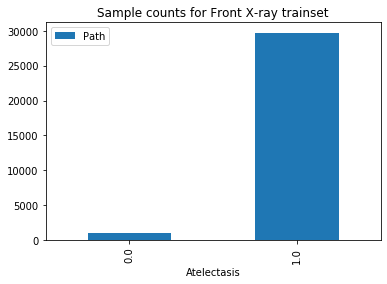

In [173]:
# checking out the distribution of samples
filtered_front.groupby(['Atelectasis']).count().plot(kind='bar',title='Sample counts for Front X-ray trainset')

In [174]:
# seperating the positive and negative entries
negatives = filtered_front[filtered_front.Atelectasis==0]
positives = filtered_front[filtered_front.Atelectasis==1]

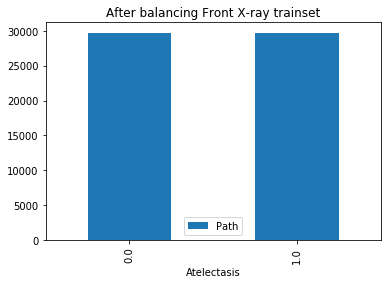

In [175]:
# Obtaining the larger group count
upper_limit = np.max(filtered_front.groupby(['Atelectasis']).count().Path.values)

negative_upsampled = resample(negatives, 
                                 replace=True,     # sample with replacement
                                 n_samples=upper_limit,    # to match majority class
                                 random_state=24) 

# Combine majority class with upsampled minority class
filtered_front = pd.concat([positives, negative_upsampled])

# This is to shuffle the new dataframe (mix 0s and 1s) and reset the index
filtered_front = filtered_front.sample(frac=1).reset_index(drop=True)

filtered_front.groupby(['Atelectasis']).count().plot(kind='bar',title='After balancing Front X-ray trainset')

#### Lateral X-ray trainset



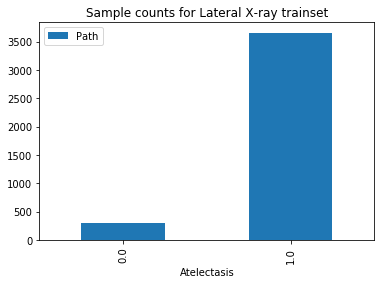

In [177]:
# checking out the distribution of samples
filtered_lat.groupby(['Atelectasis']).count().plot(kind='bar',title='Sample counts for Lateral X-ray trainset')

In [178]:
# seperating the positive and negative entries
negatives = filtered_lat[filtered_lat.Atelectasis==0]
positives = filtered_lat[filtered_lat.Atelectasis==1]

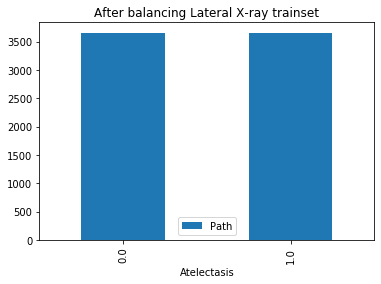

In [179]:
# Obtaining the larger group count
upper_limit = np.max(filtered_lat.groupby(['Atelectasis']).count().Path.values)

negative_upsampled = resample(negatives, 
                                 replace=True,     # sample with replacement
                                 n_samples=upper_limit,    # to match majority class
                                 random_state=24) 

# Combine majority class with upsampled minority class
filtered_lat = pd.concat([positives, negative_upsampled])

# This is to shuffle the new dataframe (mix 0s and 1s) and reset the index
filtered_lat = filtered_lat.sample(frac=1).reset_index(drop=True)

filtered_lat.groupby(['Atelectasis']).count().plot(kind='bar',title='After balancing Lateral X-ray trainset')

## Separating them into X and y
* X will contain the paths to the images 
* y will contain the respective Atelectasis feature

#### For front trainset

In [182]:
atel_front_X = filtered_front.Path.values
# need to reshape to make it [[0],[1],[1]...]
atel_front_y = filtered_front.Atelectasis.values.reshape(-1,1)

print('X: {}\ny: {}'.format(atel_front_X[:2],atel_front_y[:2]))

X: ['CheXpert-v1.0-small/train/patient34791/study3/view1_frontal.jpg'
 'CheXpert-v1.0-small/train/patient32020/study2/view1_frontal.jpg']
y: [[1.]
 [0.]]


#### For front validation set

In [183]:
atelv_front_X = filteredv_front.Path.values
# need to reshape to make it [[0],[1],[1]...]
atelv_front_y = filteredv_front.Atelectasis.values.reshape(-1,1)

print('X: {}\ny: {}'.format(atelv_front_X[:2],atelv_front_y[:2]))

X: ['CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'
 'CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg']
y: [[0.]
 [0.]]


#### For Lateral trainset

In [184]:
atel_lat_X = filtered_lat.Path.values
# need to reshape to make it [[0],[1],[1]...]
atel_lat_y = filtered_lat.Atelectasis.values.reshape(-1,1)

print('X: {}\ny: {}'.format(atel_lat_X[:2],atel_lat_y[:2]))

X: ['CheXpert-v1.0-small/train/patient23508/study1/view2_lateral.jpg'
 'CheXpert-v1.0-small/train/patient15936/study1/view2_lateral.jpg']
y: [[0.]
 [1.]]


#### For Lateral validation set

In [185]:
atelv_lat_X = filteredv_lat.Path.values
# need to reshape to make it [[0],[1],[1]...]
atelv_lat_y = filteredv_lat.Atelectasis.values.reshape(-1,1)

print('X: {}\ny: {}'.format(atelv_lat_X[:2],atelv_lat_y[:2]))

X: ['CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg'
 'CheXpert-v1.0-small/valid/patient64547/study1/view3_lateral.jpg']
y: [[0.]
 [0.]]


## Saving the cleaned Atelectasis data 

In [186]:
np.save('atelectasisX_binary_front', atel_front_X)
np.save('atelectasisy_binary_front', atel_front_y)
np.save('atelectasisXv_binary_front', atelv_front_X)
np.save('atelectasisyv_binary_front', atelv_front_y)



np.save('atelectasisX_binary_lat', atel_lat_X)
np.save('atelectasisy_binary_lat', atel_lat_y)
np.save('atelectasisXv_binary_lat', atelv_lat_X)
np.save('atelectasisyv_binary_lat', atelv_lat_y)

# Pre Modeling
Here we 
* load the images (its a good practice to load it from hardisk although the variables are already there in the notebook. )
* create generators that handle real-time augmentation when training the models

#### NOTE: the codes were compiled from multiple notebooks, hence, some blocks are not ment to be executed sequentially

#### WARNING: loading images is a highly memory intensive process, i did not load both lateral and frontal into memory at once and i highly suggest you do the same
* They are placed in one section for the storyline flow only
* i would suggest you only execute one block (lateral or frontal)
* then proceed to the other parts of pre-modeling and modeling

In [ ]:
# LOADING FRONTAL X-rays to memory
X = load_imgs_from_array(root,np.load('atelectasisX_binary_front.npy',allow_pickle=True))
y = np.load('atelectasisy_binary_front.npy',allow_pickle=True)

Xv = load_imgs_from_array(root,np.load('atelectasisXv_binary_front.npy', allow_pickle=True))
yv = np.load('atelectasisyv_binary_front.npy', allow_pickle=True)

In [6]:
# LOADING LATERAL X-rays to memory
X = load_imgs_from_array(root,np.load('atelectasisX_binary_lat.npy',allow_pickle=True))
y = np.load('atelectasisy_binary_lat.npy',allow_pickle=True)

Xv = load_imgs_from_array(root,np.load('atelectasisXv_binary_lat.npy', allow_pickle=True))
yv = np.load('atelectasisyv_binary_lat.npy', allow_pickle=True)

#### Checking out the dimensions of the loaded images and viewing them

In [7]:
X.shape,y.shape

((7312, 300, 300, 3), (7312, 1))

Text(0.5, 1.0, 'Negative Atelectasis Lateral X-ray')

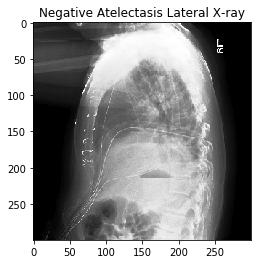

In [8]:
plt.imshow(X[0])
plt.title("{} Atelectasis Lateral X-ray".format('Positive' if y[0] == 1. else 'Negative'))

Text(0.5, 1.0, 'Positive Atelectasis Lateral X-ray')

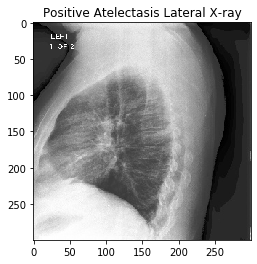

In [9]:
plt.imshow(X[1])
plt.title("{} Atelectasis Lateral X-ray".format('Positive' if y[1] == 1. else 'Negative'))

## Making the augmentation Generators
For augmentation, there will be:
* Random 15 degree rotation
* random 10% of the total length/ width of the image shift

below is just a demo on how the image will look like after each augmentation

Text(0.5, 1.0, 'Original Image')

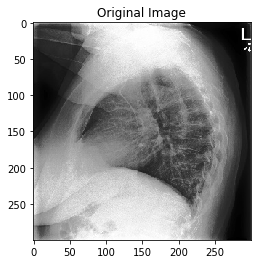

In [10]:
plt.imshow(X[-1]); plt.title('Original Image')

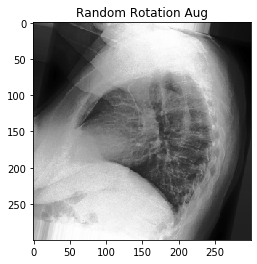

In [24]:
tmp = tf.keras.preprocessing.image.random_rotation(
    X[-1], 15, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0,
    interpolation_order=1
)
plt.imshow(tmp)
plt.title('Random Rotation Aug')
plt.show()

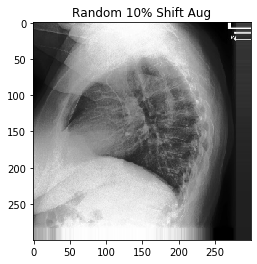

In [25]:
tmp = tf.keras.preprocessing.image.random_shift(
    X[-1], 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest',
    cval=0.0, interpolation_order=1
)

plt.imshow(tmp)
plt.title('Random 10% Shift Aug')
plt.show()

To do all the above augmentation on the go (Without the need to pre-produce the augmented images) we will use ImageDataGenerator

#### Note: make sure you have both tensor flow 2 and the latest version of keras otherwise this will not work as expected and you have to replace it with the custom generator i built at the bottom of the notebook

In [26]:
# Instantiating the Image generator
Gin = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    data_format = "channels_last") # because or data is (batch_size,width,height,color_channels)

# .flow() will create the generater which keeps providing images in batches
TrainGenerator = Gin.flow(X,y)

# Modeling

In this section we will run three experiments, the first two experiments invovles a pre-trained model. Hence, ResNet50 and VGG16 were chosen
1. Using a pre-trained model to extract features then train a classification layer
2. Using a pre-trained model to fine-tune a new architecture
3. Creating an architecture from stractch

## Feature Extraction
Here we will compare the results when using each VGG and ResNet models for feature extraction

## Frontal X-rays results
#### resnet as feature extractor

In [28]:

# Importing the pre-trained model without the classification layer
resnet = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(300,300,3))

# making a Sequential model
md = Sequential()

# adding the pre-trained model to sequential
md.add(resnet)

# flattening the features extracted from resnet
md.add(Flatten())

# add a dropout layer to turn off few weights to avoid overfitting
md.add(Dropout(0.4))

# add a classification layer with sigmoid act to range the output between 0 and 1
md.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the resnet pre-trained model (we dont want to train it, just to use it to extract features)
md.layers[0].trainable = False


md.compile(loss='binary_crossentropy', #because we have a single class
              optimizer='adam',
              metrics=['AUC'])
md.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 204801    
Total params: 23,792,513
Trainable params: 204,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [36]:
# early stopping if validation AreaUnderCurve did not improve for 5 epochs
# also save the best model 
callbacks = [EarlyStopping(monitor='val_auc', patience=5),
             ModelCheckpoint(filepath='atel_front_FE_resnet_model.h5', monitor='val_auc', save_best_only=True)]



history = md.fit_generator(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(X.shape[0]/32)*2, # batch size of 32 but we want to generate 2 augmented images for each sample
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
128/128 [==============================] - 414s 3s/step - loss: 1.8569 - auc: 0.5491 - val_loss: 0.7222 - val_auc: 0.6047
Epoch 2/30
128/128 [==============================] - 410s 3s/step - loss: 1.4180 - auc: 0.5358 - val_loss: 1.4835 - val_auc: 0.6214
Epoch 3/30
128/128 [==============================] - 401s 3s/step - loss: 1.4225 - auc: 0.5459 - val_loss: 1.9727 - val_auc: 0.6181
Epoch 4/30
128/128 [==============================] - 392s 3s/step - loss: 1.3542 - auc: 0.5365 - val_loss: 1.4017 - val_auc: 0.6210
Epoch 5/30
128/128 [==============================] - 392s 3s/step - loss: 1.4044 - auc: 0.5537 - val_loss: 1.8442 - val_auc: 0.6396
Epoch 6/30
128/128 [==============================] - 391s 3s/step - loss: 1.6579 - auc: 0.5613 - val_loss: 0.6830 - val_auc: 0.6506


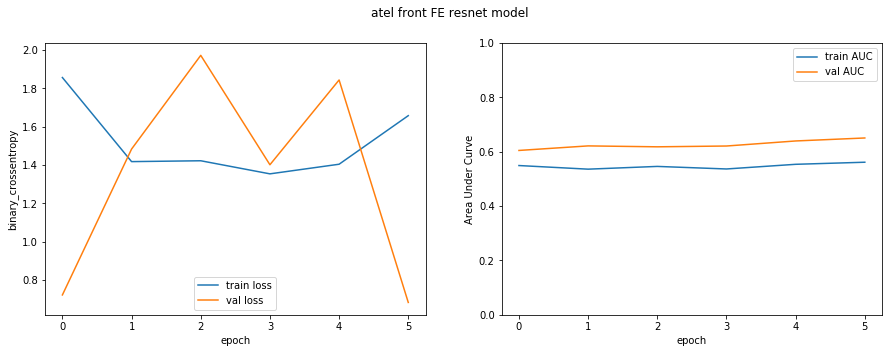

In [40]:
viz_progress(history,"atel front FE resnet model")


From the plots above i can interpret that the model is not learning as the Area Under Curve remains almost constant. However, there seems to be a fluctuation in the loss.

My conclusion is that the model is predicting all ones or all zeros which explains why the AUC is almost constant. However, it was getting closer to the classification threshold or further away with each epoch which expains the fluctuation in the loss value.

This is sad but im happy because to see McDonalds sign in the plot

In [49]:
# make predictions on validation data
pred=md.predict(X_v)

# plot the confusion matrix
# calssification threshold set to 0.5 that is why its not the same as the results obtained above
confuseme(y_v,[1 if p[0]>.5 else 0 for p in pred ])

Confusion Matrix : 
 [[ 13  14]
 [ 62 113]]
Accuracy :  0.6237623762376238
Sensitivity :  0.48148148148148145
Specificity :  0.6457142857142857


#### VGG as feature extractor


In [57]:

vg = tf.keras.applications.VGG16(include_top=False, input_shape=(300,300,3),weights='imagenet')
md = Sequential()
md.add(vg)
md.add(Flatten())
md.add(Dense(1, activation='sigmoid'))
md.layers[0].trainable = False
md.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41473     
Total params: 14,756,161
Trainable params: 41,473
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
md.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC'])

In [59]:
callbacks = [EarlyStopping(monitor='val_auc', patience=5),
             ModelCheckpoint(filepath='atel_front_FE_vgg_model.h5', monitor='val_auc', save_best_only=True)]

history = md.fit_generator(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(X.shape[0]/32)*2,
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
128/128 [==============================] - 940s 7s/step - loss: 0.8143 - auc: 0.5965 - val_loss: 0.6010 - val_auc: 0.7306
Epoch 2/30
128/128 [==============================] - 972s 8s/step - loss: 0.6784 - auc: 0.6622 - val_loss: 0.5730 - val_auc: 0.7335
Epoch 3/30
128/128 [==============================] - 1016s 8s/step - loss: 0.6847 - auc: 0.6724 - val_loss: 0.6004 - val_auc: 0.7074
Epoch 4/30
128/128 [==============================] - 962s 8s/step - loss: 0.6578 - auc: 0.6960 - val_loss: 0.6258 - val_auc: 0.6762
Epoch 5/30
128/128 [==============================] - 1109s 9s/step - loss: 0.6419 - auc: 0.7133 - val_loss: 0.7319 - val_auc: 0.7238
Epoch 6/30
128/128 [==============================] - 1118s 9s/step - loss: 0.6377 - auc: 0.7316 - val_loss: 0.8041 - val_auc: 0.7145
Epoch 7/30
128/128 [==============================] - 1210s 9s/step - loss: 0.6135 - auc: 0.7421 - val_loss: 0.7186 - val_auc: 0.6817
Epoch 8/30
128/128 [==============================] - 1147s 9s/st

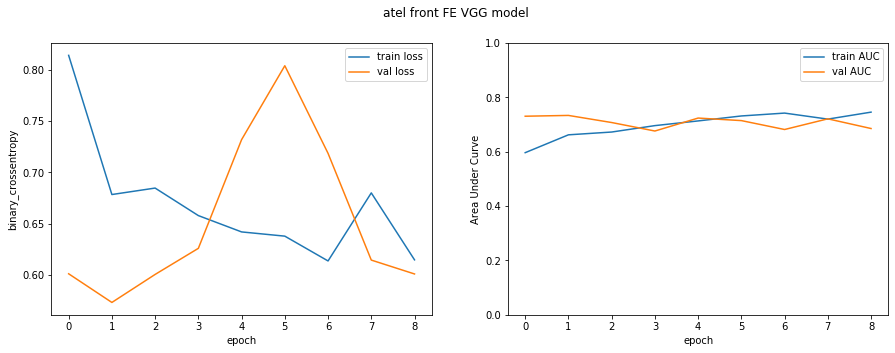

In [60]:
viz_progress(history,"atel front FE VGG model")

In [61]:
pred=md.predict(X_v)

In [63]:
confuseme(y_v,[1 if p[0]>.5 else 0 for p in pred ])

Confusion Matrix : 
 [[26 33]
 [49 94]]
Accuracy :  0.594059405940594
Sensitivity :  0.4406779661016949
Specificity :  0.6573426573426573


Both RESNET50 and VGG16 acheived a validation accuracy of 63.02% or below and a validation loss below 0.61 when used as a feature extracter. hence, below i will be using the fine tuning method instead of feature extraction.

## Lateral X-ray results

#### VGG as a feature extractor

In [11]:
# import pre-trained model
vg = tf.keras.applications.VGG16(include_top=False, input_shape=(300,300,3),weights='imagenet')
# making a sequential model
md = Sequential()
# adding the pretrained model
md.add(vg)
# flattening the extracted features
md.add(Flatten())
# adding a classification layer 
md.add(Dense(1, activation='sigmoid'))
# freezing the pre-trained model
md.layers[0].trainable = False


md.summary()

md.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])
md.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41473     
Total params: 14,756,161
Trainable params: 41,473
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
___________________

In [13]:
# early stopping if binary accuracy of validation is not improving for 3 epochs
callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=3),
             ModelCheckpoint(filepath='atel_lat_FE_vgg.h5', monitor='val_binary_accuracy', save_best_only=True)]

history = md.fit(TrainGenerator,validation_data=(X_v,y_v),
                    steps_per_epoch=math.floor(X.shape[0]/32),
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30


W0513 21:55:59.957580 11496 deprecation.py:506] From C:\Users\TB\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


228/228 [==============================] - 1609s 7s/step - loss: 0.6223 - auc: 0.7369 - binary_accuracy: 0.6758 - val_loss: 0.8053 - val_auc: 0.7812 - val_binary_accuracy: 0.5926
Epoch 2/30
228/228 [==============================] - 1615s 7s/step - loss: 0.5031 - auc: 0.8349 - binary_accuracy: 0.7573 - val_loss: 0.4527 - val_auc: 0.8704 - val_binary_accuracy: 0.6667
Epoch 3/30
228/228 [==============================] - 1619s 7s/step - loss: 0.4412 - auc: 0.8758 - binary_accuracy: 0.7979 - val_loss: 0.6100 - val_auc: 0.8443 - val_binary_accuracy: 0.7407
Epoch 4/30
228/228 [==============================] - 1630s 7s/step - loss: 0.4044 - auc: 0.8973 - binary_accuracy: 0.8195 - val_loss: 0.6473 - val_auc: 0.8107 - val_binary_accuracy: 0.7778
Epoch 5/30
228/228 [==============================] - 1626s 7s/step - loss: 0.3671 - auc: 0.9174 - binary_accuracy: 0.8420 - val_loss: 0.9333 - val_auc: 0.8141 - val_binary_accuracy: 0.5926
Epoch 6/30
228/228 [==============================] - 1645s 7

Max Validation accuracy 77%

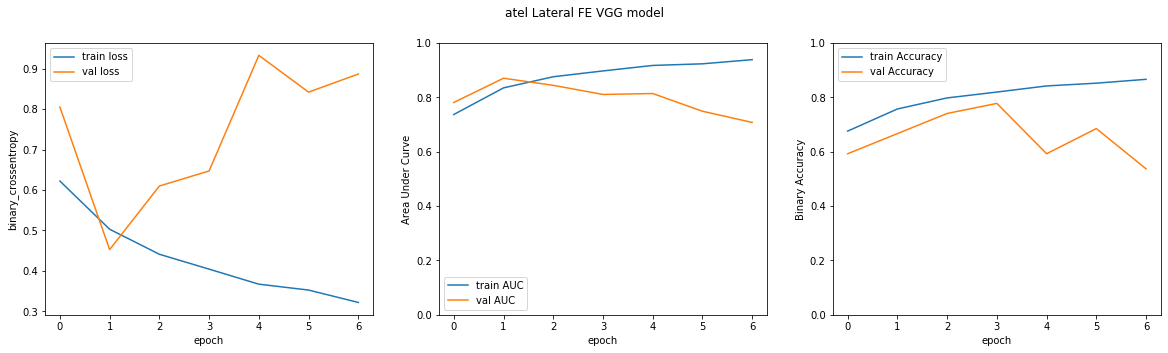

In [18]:
viz_progress1(history,"atel Lateral FE VGG model")

* Validation loss started to  increase after 1 epoch
* Model seems to perform worse after 1st epoch as seen from AUC and loss
* although accuracy was increasing untill 3rd epoch
* overfitting started after 3rd epoch

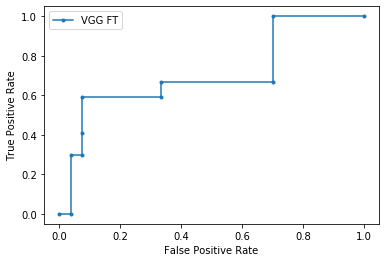

In [23]:
pred=md.predict(Xv)
plot_roc_curve(Xv, pred)

Here the TPR/FPR plot is to help pick the optimal threshold value

In [31]:
confuseme(Xv,[1 if p[0]>0.15 else 0 for p in pred ])

Confusion Matrix : 
 [[ 3  0]
 [24 27]]
Accuracy :  0.5555555555555556
Sensitivity :  1.0
Specificity :  0.5294117647058824


## Fine Tuning

## Frontal X-rays results

#### resnet fine tuning

In [94]:
# import the pretrained model without the classification layer
resnet = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(300,300,3))

resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [95]:
# freazing all the weights except the last 4 layers for the pre-trained model
for l in resnet.layers[:-4]:
    l.trainable = False


In [97]:
# making a sequential model
md = Sequential()

# adding the pretrained partially frozen model
md.add(resnet)

# adding a convolutional layer
md.add(Conv2D(128,(7,7)))

# adding maxpooling to reduce dimensionality and summarize the features
md.add(MaxPooling2D())

# relu activation
md.add(Activation('relu'))

# prepare for classification layers by flattening
md.add(Flatten())

# dense layer (Fully connected)
md.add(Dense(256, activation='relu'))

# classification layer with sigmoid to squish the values to the range between 0 and 1
md.add(Dense(1, activation='sigmoid'))

md.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         12845184  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
activation (Activation)      (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [98]:
md.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])


In [99]:

callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=5),
             ModelCheckpoint(filepath='atel_front_FT_resnet_model.h5', monitor='val_binary_accuracy', save_best_only=True)]

history = md.fit_generator(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(X.shape[0]/32)*2,
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
128/128 [==============================] - 589s 5s/step - loss: 1.6840 - auc: 0.5059 - binary_accuracy: 0.5050 - val_loss: 0.6675 - val_auc: 0.5823 - val_binary_accuracy: 0.5743
Epoch 2/30
128/128 [==============================] - 549s 4s/step - loss: 0.7154 - auc: 0.5371 - binary_accuracy: 0.5166 - val_loss: 0.6804 - val_auc: 0.5430 - val_binary_accuracy: 0.5594
Epoch 3/30
128/128 [==============================] - 545s 4s/step - loss: 0.6991 - auc: 0.5425 - binary_accuracy: 0.5334 - val_loss: 0.6966 - val_auc: 0.5899 - val_binary_accuracy: 0.4901
Epoch 4/30
128/128 [==============================] - 542s 4s/step - loss: 0.7020 - auc: 0.5123 - binary_accuracy: 0.5050 - val_loss: 0.6937 - val_auc: 0.5000 - val_binary_accuracy: 0.3713
Epoch 5/30
128/128 [==============================] - 543s 4s/step - loss: 0.6931 - auc: 0.5073 - binary_accuracy: 0.5089 - val_loss: 0.6909 - val_auc: 0.5000 - val_binary_accuracy: 0.6287
Epoch 6/30
128/128 [==============================] - 5

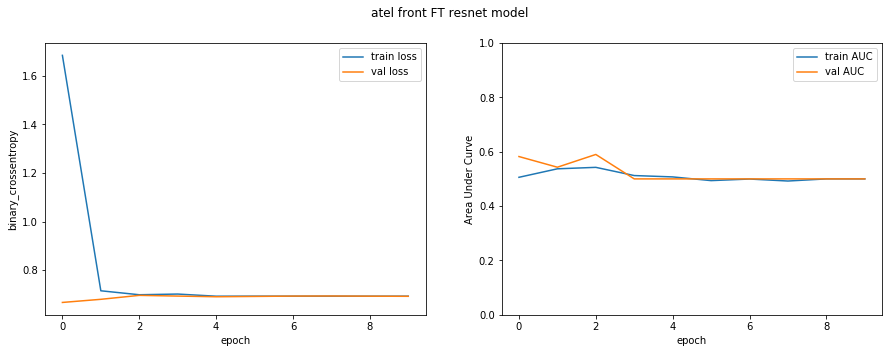

In [100]:
viz_progress(history,"atel front FT resnet model")

Here we can see that the model did not learn at all

In [101]:
pred=md.predict(Xv)

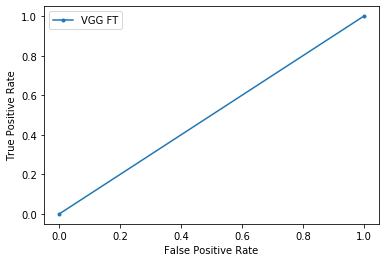

In [102]:
plot_roc_curve(yv, pred)

In [106]:
confuseme(yv,[1 if p[0]>.5 else 0 for p in pred ])

Confusion Matrix : 
 [[  0   0]
 [ 75 127]]
Accuracy :  0.6287128712871287
Sensitivity :  nan
Specificity :  0.6287128712871287


C:\Users\TB\Anaconda3\envs\AI_Playground\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars


* accuracy above 50% because the validation sample is not balanced
* model tends to classify everything as positive when the threshold is 0.5
* out of the possitive classifications, 37% of them were False positives

### VGG fine tuning

In [107]:
# importing the VGG model
vg = tf.keras.applications.VGG16(include_top=False, input_shape=(300,300,3),weights='imagenet')
vg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [108]:
# freazing all the layers except the last 4
for l in vg.layers[:-4]:
    l.trainable = False

# making a sequential model
md = Sequential()

# adding the partially frozen pre-trained model as the first layer
md.add(vg)
# adding convolutional layer with 128 filters of size 7x7
md.add(Conv2D(128,(7,7)))

# adding maxpooling layer reduce dimensionality
md.add(MaxPooling2D())

# adding relu activation to convert negative values to 0
md.add(Activation('relu'))

# flatten the filters to prepare for dense layers
md.add(Flatten())

# dense layer with 256 nodes ending with a relu activation
md.add(Dense(256, activation='relu'))

# last classification layer 
md.add(Dense(1, activation='sigmoid'))

md.summary()



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         3211392   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

In [110]:
md.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])



In [111]:

callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=5),
             ModelCheckpoint(filepath='atel_front_FT_vgg_model.h5', monitor='val_binary_accuracy', save_best_only=True)]

history = md.fit_generator(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(X.shape[0]/32)*2,
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)


Epoch 1/30
128/128 [==============================] - 1242s 10s/step - loss: 0.7364 - auc: 0.4918 - binary_accuracy: 0.4886 - val_loss: 0.6914 - val_auc: 0.5000 - val_binary_accuracy: 0.6287
Epoch 2/30
128/128 [==============================] - 1134s 9s/step - loss: 0.6932 - auc: 0.4926 - binary_accuracy: 0.4908 - val_loss: 0.6918 - val_auc: 0.5000 - val_binary_accuracy: 0.6287
Epoch 3/30
128/128 [==============================] - 1144s 9s/step - loss: 0.6933 - auc: 0.4917 - binary_accuracy: 0.4960 - val_loss: 0.6930 - val_auc: 0.5000 - val_binary_accuracy: 0.6287
Epoch 4/30
128/128 [==============================] - 1139s 9s/step - loss: 0.6932 - auc: 0.4949 - binary_accuracy: 0.4943 - val_loss: 0.6923 - val_auc: 0.5000 - val_binary_accuracy: 0.6287
Epoch 5/30
128/128 [==============================] - 1137s 9s/step - loss: 0.6932 - auc: 0.5000 - binary_accuracy: 0.4889 - val_loss: 0.6943 - val_auc: 0.5000 - val_binary_accuracy: 0.3713
Epoch 6/30
128/128 [=============================

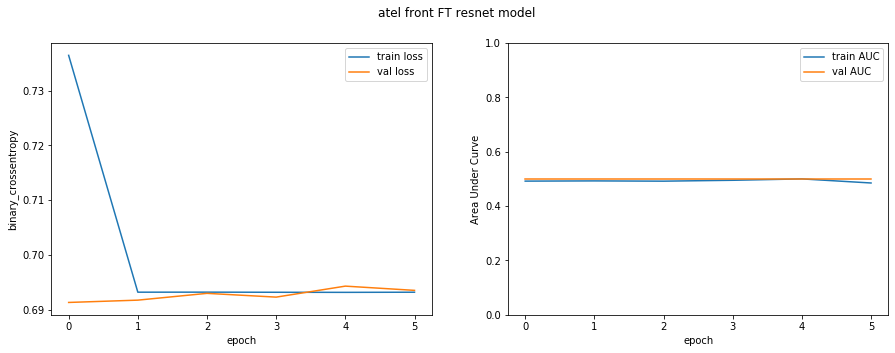

In [112]:
viz_progress(history,"atel front FT resnet model")

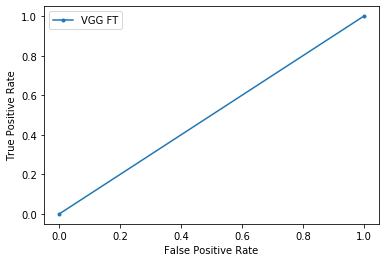

In [114]:
pred=md.predict(X_v)
plot_roc_curve(y_v, pred)

In [115]:
confuseme(y_v,[1 if p[0]>.5 else 0 for p in pred ])

Confusion Matrix : 
 [[ 75 127]
 [  0   0]]
Accuracy :  0.3712871287128713
Sensitivity :  0.3712871287128713
Specificity :  nan


C:\Users\TB\Anaconda3\envs\AI_Playground\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


From the plots and results above
* The model is not learning
* model classified everything as negative 
* validation data is not balanced which explains why the accuracy is lower than 50%

## Lateral X-rays

#### fine tuning a VGG

In [32]:
# following the same procedure as above so i will stop commenting :D

vg = tf.keras.applications.VGG16(include_top=False, input_shape=(300,300,3),weights='imagenet')
for l in vg.layers[:-4]:
    l.trainable = False


md = Sequential()
md.add(vg)

md.add(Conv2D(128,(7,7)))
md.add(MaxPooling2D())
md.add(Activation('relu'))
md.add(Flatten())


md.add(Dense(256, activation='relu'))

md.add(Dense(1, activation='sigmoid'))

md.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 128)         3211392   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 128)         0         
_________________________________________________________________
activation (Activation)      (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [33]:
md.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])

In [34]:
callbacks = [EarlyStopping(monitor='val_auc', patience=2),
             ModelCheckpoint(filepath='atel_lat_FT_vgg.h5', monitor='val_auc', save_best_only=True)]

history = md.fit(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(X.shape[0]/32),
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
228/228 [==============================] - 1874s 8s/step - loss: 0.7314 - auc: 0.5000 - binary_accuracy: 0.5025 - val_loss: 0.6932 - val_auc: 0.5000 - val_binary_accuracy: 0.5000
Epoch 2/30
228/228 [==============================] - 1848s 8s/step - loss: 0.6932 - auc: 0.4995 - binary_accuracy: 0.5003 - val_loss: 0.6932 - val_auc: 0.5000 - val_binary_accuracy: 0.5000
Epoch 3/30
228/228 [==============================] - 1844s 8s/step - loss: 0.6932 - auc: 0.5000 - binary_accuracy: 0.4900 - val_loss: 0.6931 - val_auc: 0.5000 - val_binary_accuracy: 0.5000


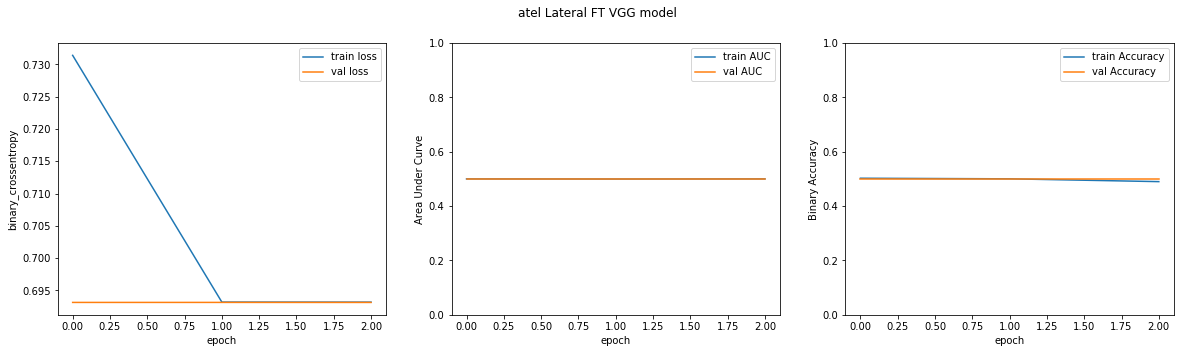

In [35]:
viz_progress1(history,"atel Lateral FT VGG model")

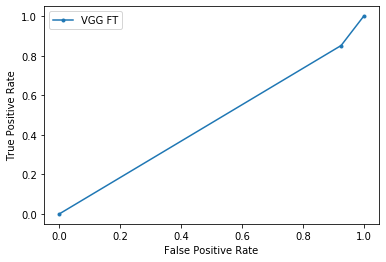

In [36]:
pred=md.predict(loaded_atellatv_X)
plot_roc_curve(atellatv_y, pred)

In [38]:
confuseme(atellatv_y,[1 if p[0]>0.5 else 0 for p in pred ])

Confusion Matrix : 
 [[27 27]
 [ 0  0]]
Accuracy :  0.5
Sensitivity :  0.5
Specificity :  nan


C:\Users\TB\Anaconda3\envs\AI_Playground\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in longlong_scalars


Conclusion is that the model did not learn, could be from the difference in the architecture of the pre-trained model and the added layers what causing the issue

## Making a model from scratch

### Frontal-Xrays

In [124]:
# trying out Stochastic Gradient Descend
from tensorflow.keras.optimizers import SGD
# Setting a high learning rate which decays over time by a rate of 0.001
SGD = SGD(lr= 0.01, decay=0.001)

In [127]:
# Making the model architecture
model = Sequential()

model.add(Conv2D(32, (7, 7), input_shape=(300, 300, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (7, 7)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten()) 
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD,
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])

In [128]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=6),
             ModelCheckpoint(filepath='atel_front_scratch1_model.h5', monitor='val_binary_accuracy', save_best_only=True)]

history = model.fit_generator(TrainGenerator,validation_data=(Xv,yv),
                    steps_per_epoch=math.floor(atelX.shape[0]/32)*2,
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
128/128 [==============================] - 636s 5s/step - loss: 0.6889 - auc: 0.5547 - binary_accuracy: 0.5367 - val_loss: 0.7073 - val_auc: 0.6152 - val_binary_accuracy: 0.5000
Epoch 2/30
128/128 [==============================] - 638s 5s/step - loss: 0.6834 - auc: 0.5827 - binary_accuracy: 0.5644 - val_loss: 0.6573 - val_auc: 0.6212 - val_binary_accuracy: 0.6386
Epoch 3/30
128/128 [==============================] - 636s 5s/step - loss: 0.6777 - auc: 0.5967 - binary_accuracy: 0.5716 - val_loss: 0.6626 - val_auc: 0.6245 - val_binary_accuracy: 0.6188
Epoch 4/30
128/128 [==============================] - 649s 5s/step - loss: 0.6759 - auc: 0.6033 - binary_accuracy: 0.5733 - val_loss: 0.6664 - val_auc: 0.6306 - val_binary_accuracy: 0.6188
Epoch 5/30
128/128 [==============================] - 651s 5s/step - loss: 0.6713 - auc: 0.6172 - binary_accuracy: 0.5857 - val_loss: 0.6363 - val_auc: 0.6362 - val_binary_accuracy: 0.6485
Epoch 6/30
128/128 [==============================] - 6

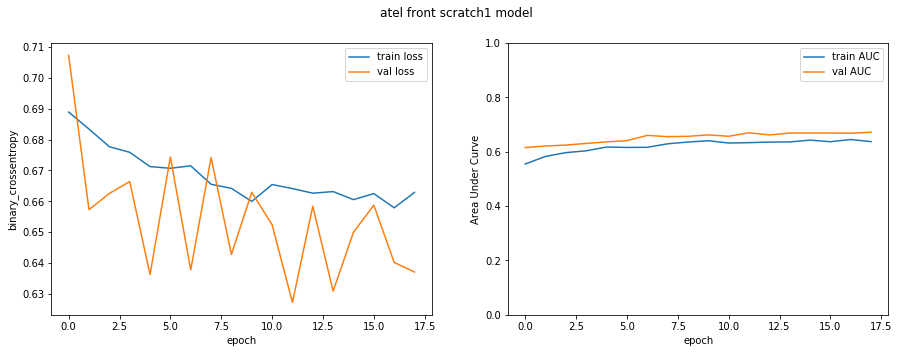

In [129]:
viz_progress(history,"atel front scratch1 model")

From the loss function i can tell that the model is slightly improving however, AUC tells me that the model prediction is almost constantly making the same rate of mistakes.

My conclusion is that the model classified all as either negative or positive and its prediction is getting closer or further to the threshold which explains why the loss in improving over time

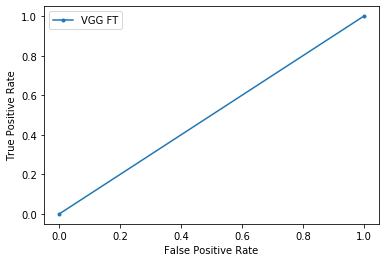

In [130]:
pred=md.predict(X_v)
plot_roc_curve(y_v, pred)

In [131]:
confuseme(y_v,[1 if p[0]>.5 else 0 for p in pred ])

Confusion Matrix : 
 [[ 75 127]
 [  0   0]]
Accuracy :  0.3712871287128713
Sensitivity :  0.3712871287128713
Specificity :  nan


C:\Users\TB\Anaconda3\envs\AI_Playground\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


### Lateral X-rays

In [97]:
from tensorflow.keras.optimizers import SGD
SGD = SGD(lr= 0.01, decay=0.001)
model = Sequential()
model.add(Conv2D(32, (50, 50), input_shape=(300, 300, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (11, 11)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (11, 11)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  

model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 251, 251, 32)      240032    
_________________________________________________________________
batch_normalization_27 (Batc (None, 251, 251, 32)      128       
_________________________________________________________________
activation_46 (Activation)   (None, 251, 251, 32)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 115, 115, 64)      247872    
_________________________________________________________________
batch_normalization_28 (Batc (None, 115, 115, 64)      256       
_________________________________________________________________
activation_47 (Activation)   (None, 115, 115, 64)    

In [98]:
callbacks = [EarlyStopping(monitor='val_auc', patience=3),
             ModelCheckpoint(filepath='atel_lat_scratch1_model2.h5', monitor='val_auc', save_best_only=True)]

history = model.fit(TrainGenerator,validation_data=(loaded_atellatv_X,atellatv_y),
                    steps_per_epoch=math.floor(loaded_atellat_X.shape[0]/32),
                    verbose=1,
                    epochs = 30,
                    callbacks = callbacks)

Epoch 1/30
228/228 [==============================] - 9772s 43s/step - loss: 0.9046 - auc: 0.6200 - binary_accuracy: 0.5975 - val_loss: 0.8350 - val_auc: 0.6118 - val_binary_accuracy: 0.5556
Epoch 2/30
228/228 [==============================] - 9673s 42s/step - loss: 0.7655 - auc: 0.6502 - binary_accuracy: 0.6069 - val_loss: 1.0393 - val_auc: 0.5494 - val_binary_accuracy: 0.5370
Epoch 3/30
 12/228 [>.............................] - ETA: 2:35:02 - loss: 0.7366 - auc: 0.6591 - binary_accuracy: 0.6172

KeyboardInterrupt: 

I had to stop it because as you can see from the first 2 epoches that it is not learning and each epoch takes more than the estimated 2 hours time which is time consuming.

In conclusion, i suspect that the models are not learning as the first few layers' filters are of a very small size which fail to extract features from the image properly which ultimately leads to simple features in later layers which fail to extract any usefull patterns from the image. Or i just need to run this on few days, i dont know.

# Using the best model obtained for predictions

In [30]:
# you can choose from all the models saved above
# this is the model that obtained 77% validation accuracy on Lateral images
loaded_model = tf.keras.models.load_model('atel_lat_FE_vgg.h5')

In [46]:
# using the model to make predictions
# NOTE: this model only works on lateral images
# expand_dims is to convert (300,300,3) to (1,300,300,3) (add the batch size)
image_num = 6
pred = loaded_model.predict(expand_dims(Xv[image_num],0))

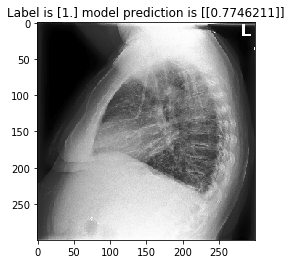

In [47]:
plt.imshow(Xv[image_num])
plt.title("Label is {} model prediction is {}".format(yv[image_num],pred))
plt.show()

# Conclusion

Below are the findings obtained from this project
1. Producing a convolutional Neural Network (CNN) model with a deployable accuracy (higher than 98% accuracy for healthcare) is a difficult task, this explains why we do not see AI and machine learning deployed in hospitals yet.
2. The best accuracy obtained from this project was 77% when we used VGG16 model to extract the features to train our classification layer
3. Fine tuning an architecture such as VGG16 requires extensive research on the layers and and a thruout understanding of the purpose of each layer which is not an easy task.
4. Creating a model from scratch requires extensive processing power. From my search online, there is no golden rule for layers selection (layer filter size ratio, number of filters ratio, etc...) which makes it a difficult task especially when training time is long but required to see how your model is behaving

# Thank you

**I would like to thank all the Instructional team (Irfan, Husein, Yazeid and Amjad) for there outstanding effort in teaching us and facilitating the learning curve. I guarentee that taking this course will be the best decision i will ever make in 2020, not only because of the quality training i received, but the great mentorship and brotherhood i have experienced in this course thanks to the instructors and fellow students.**


**Also thank you for viewing my submission, i wish you a great life full of adventures and joy!, hope we cross paths someday.**
----------------------------------------------------------------------------------------------------





Below is a class for a modified image generator i did because i was working with the old tensorflow & keras combo and the feature i was looking for wasn't implemented the way i want (loading and augmenting images on the go, images returned are super dark bug) but then decided to update the tensorflow before prezentation by a day and all hell broke loose.

It is not necessary anymore because the ImageDataGenerator works great in the new TensorFlow2 but i felt bad removing it especially after spending a lot of time reading about how to modify the data generator 

In [24]:
class DataGenerator(keras.utils.Sequence):
    '''Load images and generate augmented versions on the go
    path_list: your paths of images. must be an array of paths
    labels: labels must be a dictionary where keys are the path of the image and value is the label  
    batch_size: the number of images used to generate each augmented batch
    sample_per_img: if 1, no augmentation is done, if more than it would double the batch size by adding n augmented version for each image
    dim: the desired output dimensions of the image (Width,Height)
    n_channels: the desired number of color channels (set to 1 for grayscale)
    n_classes: number of classes in your label
    shuffle: set to True to shuffle your data after each epoch
    
    '''    
    def __init__(self, path_list, labels, batch_size=32, sample_per_img = 1, dim=(300,300), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.sample_per_img = sample_per_img
        self.labels = labels
        self.path_list = path_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.root = 'D:\\Capstone\\CheXpert-v1.0-small'
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        # number of samples / batch size
        # so the model seas each sample once per epoch
        return int(np.floor(len(self.path_list) / self.batch_size))

    def __getitem__(self, index):
        # this will generate a batch of data and pass it out
        
        #get indexes of images within the specified batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # get the paths (X)
        list_IDs_temp = [self.path_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, path_list_copy):
        'get a batch of data and load the images into memory and do augmentations'

        # find out the length of the batch
        psize = len(path_list_copy)
        
        # creating the output lists
        X = np.empty((psize*self.sample_per_img, *self.dim, self.n_channels))
        y = np.empty((psize*self.sample_per_img,1))

        # For each path in the passed array
        for i, path in enumerate(path_list_copy):
            #load the image to memory from the path
            img = load_img(os.path.join(self.root,path))
            
            # repeat for n samples specified by user
            for j in range(self.sample_per_img):
                
                # for the first sample
                if i == 0 and j == 0:
                    
                    # user specified not grayscale
                    if self.n_channels > 1:
                        # gs = False for no grayscaling
                        image = self.standardize(img,self.dim[0], gs=False)
                    # user specified to grayscale
                    else:
                        image = self.standardize(img,self.dim[0], gs=True)
                        
                    # convert the result to array 
                    image = img_to_array(image, data_format = "channels_last", dtype=float)
                    # normalize the array to the range 0. to 1.
                    image = expand_dims(image,0)/255.
                    
                    # add to placeholder
                    X[self.sample_per_img*i+j,] = image
                    y[self.sample_per_img*i+j,] = self.labels[path].reshape((2))[0]
                
                # if its not the first sample (only executed if user specified n_samples more than 1)
                else:
                    # standardize the size of the image as before
                    if self.n_channels > 1:
                        image = self.standardize(img,self.dim[0], gs=False)
                    else:
                        image = self.standardize(img,self.dim[0])
                        
                    # convert to array as before
                    image = img_to_array(image, data_format = "channels_last", dtype=float)
                    # do augmentation on the image
                    image = self.augment(image,[0.1,0.1], 20, [0.5,1.])
                    # do the rest as usual
                    image = expand_dims(image,0)/255.
                    X[self.sample_per_img*i+j,] = image
                    y[self.sample_per_img*i+j,] = self.labels[path].reshape((2))[0]
                
        # X should be (n,300,300,1)
        # y should be (n,k)
        #return a shuffled X,y because samples of the same image will be clustered together
        return shuffle(X,y)
    
    def augment(self, image, srange, rotrange, brtrange):
        '''
        A function to augment the input image
        image: the original image
        srange: the percentage of shifts in [horizontal,vertical] plane
        rotrange: the maximum degree of random rotation
        brtrange: the minimum brightness range and maximum
        '''
        # apply augmentations
        img = random_shift(image, srange[0],srange[-1], row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',cval=0.0, interpolation_order=1)
        img = random_rotation(img, rotrange, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0,interpolation_order=1)
        img = random_brightness(img, [brtrange[0],brtrange[-1]])
        # return the augmented iamge
        return img
            
            
            
    def standardize(self, img, standard=100, gs=True):
        '''
        A function to resize the images to a standard sized square and convert it to grayscale if specified
        '''
        #L = R * 299/1000 + G * 587/1000 + B * 114/1000
        new_img = img.resize((standard,standard))
        if gs:
            new_img = new_img.convert('L')
        return new_img